In [1]:
#######################################################################
## IMPORTS ##
#######################################################################

import os
import itertools
import numpy as np
from numpy import linalg as nplinalg
from scipy import linalg as splinalg
import pandas as pd
import time
import matplotlib.pyplot as plt
from random import sample
import tracemalloc
import matplotlib
from matplotlib import colors
import string
import copy
from itertools import product
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures

#######################################################################
## WALSH-HADAMARD MATRIX MULTIALLELIC EXTENSION FUNCTIONS ##
#######################################################################

def H_matrix_recursive(
    sequence_length = 1,
    num_states = 2,
    invert = False):
    """
    Construct multiallelic extension of the Walsh-Hadamard (WH) transform using recursive definition.

    :param sequence_length: sequence length (default:1).
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :returns: WH matrix as Numpy array.
    """
    mat = np.asarray([[1]])
    for i in range(sequence_length):
        mat_list = []
        for j in range(num_states):
            if j==0:
                mat_list += [np.concatenate([mat]*num_states, axis = 1)]
            else:
                if invert:
                    mat_list += [[mat]*num_states]
                    mat_list[-1][j] = mat_list[-1][j]*(1-num_states)
                else:
                    mat_list += [[mat*0]*num_states]
                    mat_list[-1][0] = mat
                    mat_list[-1][j] = -mat
                mat_list[-1] = np.concatenate(mat_list[-1], axis = 1)
        mat = np.concatenate(mat_list, axis = 0)
        if invert:
            mat = (1/num_states)*mat
    return mat

def H_matrix(
    str_geno,
    str_coef,
    num_states = 2,
    invert = False):
    """
    Construct multiallelic extension of the Walsh-Hadamard (WH) transform using the formula to get elements.

    :param str_geno: list of genotype strings where '0' indicates WT state.
    :param str_coef: list of coefficient strings where '0' indicates WT state.
    :param num_states: integer number of states (identical per position) or list of integers with length matching that of sequences.
    :param invert: invert the matrix.
    :returns: WH matrix as Numpy array.
    """
    #Genotype string length
    string_length = len(str_geno[0])
    #Number of states per position in genotype string (float)
    if type(num_states) == int:
        num_states = [float(num_states) for i in range(string_length)]
    else:
        num_states = [float(i) for i in num_states]
    #Convert reference characters to "." and binary encode
    str_coef = [[ord(j) for j in i.replace("0", ".")] for i in str_coef]
    str_geno = [[ord(j) for j in i] for i in str_geno]
    #Matrix representations
    num_statesi = np.repeat([num_states], len(str_geno)*len(str_coef), axis = 0)
    str_genobi = np.repeat(str_geno, len(str_coef), axis = 0)
    str_coefbi = np.transpose(np.tile(np.transpose(np.asarray(str_coef)), len(str_geno)))
    str_genobi_eq_str_coefbi = (str_genobi == str_coefbi)
    #Factors
    row_factor2 = str_genobi_eq_str_coefbi.sum(axis = 1)
    if invert:
        row_factor1 = np.prod(str_genobi_eq_str_coefbi * (num_statesi-2) + 1, axis = 1)       
        return ((row_factor1 * np.power(-1, row_factor2))/np.prod(num_states)).reshape((len(str_geno),-1))
#         row_factor1 = np.prod(np.power(1-num_statesi, str_genobi_eq_str_coefbi), axis = 1)       
#         return (row_factor1/np.prod(num_states)).reshape((len(str_geno),-1))
    else:
        row_factor1 = (np.logical_or(np.logical_or(str_genobi_eq_str_coefbi, str_genobi==ord('0')), str_coefbi==ord('.')).sum(axis = 1) == string_length).astype(float)            
        return ((row_factor1 * np.power(-1, row_factor2))).reshape((len(str_geno),-1))

def V_matrix(
    str_coef,
    num_states = 2,
    invert = False):
    """
    Construct multiallelic extension of the diagonal weighting matrix using the formula to get elements.

    :param str_geno: list of genotype strings where '0' indicates WT state.
    :param str_coef: list of coefficient strings where '0' indicates WT state.
    :param num_states: integer number of states (identical per position) or list of integers with length matching that of sequences (default:2).
    :param invert: invert the matrix (default:False).
    :returns: diagonal weighting matrix as a numpy matrix.
    """

    #Genotype subset
    str_geno = str_coef
    #Genotype string length
    string_length = len(str_geno[0])
    #Number of states per position in genotype string
    if type(num_states) == int:
        num_states = [float(num_states) for i in range(string_length)]
    else:
        num_states = [float(i) for i in num_states]
    #Convert reference characters to "."
    str_coef_ = [i.replace("0", ".") for i in str_coef]
    #initialize V matrix
    V = np.array([[0.0]*len(str_coef)]*len(str_geno))
    #Fill matrix
    for i in range(len(str_geno)):
        factor1 = int(np.prod([c for a,b,c in zip(str_coef_[i], str_geno[i], num_states) if ord(a) != ord(b)]))
        factor2 = sum([1 for a,b in zip(str_coef_[i], str_geno[i]) if ord(a) == ord(b)])
        if invert:
            V[i,i] = factor1 * np.power(-1, factor2)
        else:
            V[i,i] = 1/(factor1 * np.power(-1, factor2))
    return V

def H_matrix_recursive_resources(
    l_start = 1,
    l_end = 10,
    num_states = 2,
    invert = False,
    invert_numerically = False,
    n_iterations = 10,
    invert_lib = 'numpy'):
    """
    Execution time and memory to construct multiallelic extension of the Walsh-Hadamard (WH) transform using recursive definition.

    :param l_start: start sequence length (default:1).
    :param l_end: end sequence length (default:10).
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param invert_numerically: invert the matrix numerically (default:False).
    :param n_iterations: number of iterations for averaging (default:10).
    :param invert_lib: library to use for matrix inversion (default:numpy).
    :returns: dictionary of pandas DataFrames with resource usage.
    """
    time_list = []
    mem_list = []
    l_range = range(l_start, l_end+1, 1)
    for j in range(n_iterations):
        for i in range(len(l_range)):
            if len(time_list)<len(l_range):
                time_list += [[]]
                mem_list += [[]]
            #record start time and memory
            tracemalloc.start()
            start = time.time()
            if invert:
                if invert_numerically:
                    if invert_lib == 'numpy':
                        nplinalg.inv(H_matrix_recursive(l_range[i], num_states))
                    if invert_lib == 'scipy':
                        splinalg.inv(H_matrix_recursive(l_range[i], num_states))
                else:
                    H_matrix_recursive(l_range[i], num_states, invert = True)
            else:
                H_matrix_recursive(l_range[i], num_states)
            #record end time and memory
            end = time.time()
            mem = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            time_list[i] += [end-start]
            mem_list[i] += [mem[1]-mem[0]]
    time_df = pd.DataFrame(time_list)
    time_df = pd.DataFrame({
        'mean' : list(time_df.mean(axis = 1)), 
        'std' : list(time_df.std(axis = 1))})
    mem_df = pd.DataFrame(mem_list)
    mem_df = pd.DataFrame({
        'mean' : list(mem_df.mean(axis = 1)), 
        'std' : list(mem_df.std(axis = 1))})
    return {'time': time_df, 'memory': mem_df}

def H_matrix_elements_resources(
    l_start = 1,
    l_end = 10,
    num_states = 2,
    invert = False,
    n_iterations = 10,
    n_elements = -1):
    """
    Execution time and memory to construct multiallelic extension of the Walsh-Hadamard (WH) transform using the formula to get elements.

    :param l_start: start sequence length (default:1).
    :param l_end: end sequence length (default:10).
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param n_iterations: number of iterations for averaging (default:10).
    :param n_elements: number of random elements to obtain (default:all).
    :returns: dictionary of pandas DataFrames with resource usage.
    """
    alphabet = ['0']+list(string.ascii_lowercase)
    time_list = []
    mem_list = []
    l_range = range(l_start, l_end+1, 1)
    for j in range(n_iterations):
        for i in range(len(l_range)):
            if len(time_list)<len(l_range):
                time_list += [[]]            
                mem_list += [[]]
            #Number of elements to extract
            n_elements_i = n_elements
            if n_elements>(np.power(num_states, l_range[i])) or n_elements==-1:
                n_elements_i = np.power(num_states, l_range[i])
            #Genotypes/coefficients
            n_geno = np.power(num_states, l_range[i])
            geno_indices = sample(range(np.power(num_states, l_range[i])),n_elements_i)
            seqs = [''.join([str(gj) for gj in [alphabet[gk] for gk in numberToBase(gi, num_states)]]).zfill(l_range[i]) for gi in geno_indices]
            #record start time
            tracemalloc.start()
            start = time.time()
            H_matrix(
                str_geno = seqs,
                str_coef = seqs,
                num_states = num_states,
                invert = invert)
            #record end time and memory
            end = time.time()
            mem = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            time_list[i] += [end-start]
            mem_list[i] += [mem[1]-mem[0]]
    time_df = pd.DataFrame(time_list)
    time_df = pd.DataFrame({
        'mean' : list(time_df.mean(axis = 1)), 
        'std' : list(time_df.std(axis = 1))})
    mem_df = pd.DataFrame(mem_list)
    mem_df = pd.DataFrame({
        'mean' : list(mem_df.mean(axis = 1)), 
        'std' : list(mem_df.std(axis = 1))})
    return {'time': time_df, 'memory': mem_df}

def plot_H_matrix(
    output_file,
    sequence_length,
    num_states = 2,
    invert = False,
    size = 4):
    """
    Plot Walsh-Hadamard matrix heatmaps.

    :param output_file: output file name.
    :param sequence_length: sequence length.
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param size: plot size (default:4).
    :returns: nothing.
    """
    #All genotypes
    all_geno = genotypeLandscape(
        sequence_length = sequence_length,
        num_states = num_states)
    #H matrix
    hmat = H_matrix(
        str_geno = all_geno,
        str_coef = all_geno,
        num_states = num_states,
        invert = invert)
    #Plot
    fig, ax = plt.subplots(figsize=(size,size))
    divnorm=colors.TwoSlopeNorm(vmin=np.min(hmat), vcenter=0., vmax=np.max(hmat))
    im = ax.pcolormesh(np.flip(hmat, axis = 0), cmap="bwr", norm=divnorm)
    fig.colorbar(im, ax=ax, shrink = 0.2, fraction = 0.5)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                   labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    ax.set_aspect('equal', adjustable='box')
    fig.tight_layout()
    plt.savefig(output_file, format="pdf", bbox_inches="tight", transparent=True)
    plt.show()

def plot_VH_matrix(
    output_file,
    sequence_length,
    num_states = 2,
    invert = False,
    size = 4):
    """
    Plot VH matrix heatmaps.

    :param output_file: output file name.
    :param sequence_length: sequence length.
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param size: plot size (default:4).
    :returns: nothing.
    """
    #All genotypes
    all_geno = genotypeLandscape(
        sequence_length = sequence_length,
        num_states = num_states)
    #H matrix
    hmat = H_matrix(
        str_geno = all_geno,
        str_coef = all_geno,
        num_states = num_states,
        invert = invert)
    #V matrix
    vmat = V_matrix(
        str_coef = all_geno,
        num_states = num_states,
        invert = invert)
    #VH matrix
    if invert:
        vhmat = np.matmul(hmat, vmat)
    else:
        vhmat = np.matmul(vmat, hmat)
    #Plot
    fig, ax = plt.subplots(figsize=(size,size))
    divnorm=colors.TwoSlopeNorm(vmin=np.min(vhmat), vcenter=0., vmax=np.max(vhmat))
    im = ax.pcolormesh(np.flip(vhmat, axis = 0), cmap="bwr", norm=divnorm)
    fig.colorbar(im, ax=ax, shrink = 0.2, fraction = 0.5)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                   labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    ax.set_aspect('equal', adjustable='box')
    fig.tight_layout()
    plt.savefig(output_file, format="pdf", bbox_inches="tight", transparent=True)
    plt.show()

def G_matrix(
    sequence_length,
    num_states,
    invert = False):
    """
    Construct G matrix.

    :param sequence_length: integer sequence length.
    :param num_states: integer number of states per position.
    :param invert: invert the matrix (default:False).
    :returns: G matrix as a numpy matrix.
    """
    all_geno = genotypeLandscape(sequence_length, num_states)
    df = pd.DataFrame({str(len(all_geno[0])-i):[j[i] for j in all_geno] for i in range(len(all_geno[0]))})
    cat_cat = make_pipeline(
        OneHotEncoder(drop = np.array(['0']*sequence_length), sparse = False),
        PolynomialFeatures(degree=sequence_length, interaction_only=True, include_bias=True)
    )
    column_trans = ColumnTransformer(
        [('ab_cat', cat_cat, df.columns)],
         remainder='drop')
    x = pd.DataFrame(column_trans.fit_transform(df), columns = column_trans.get_feature_names_out())
    col_names = column_trans.get_feature_names_out()
    col_names.sort()
    gmat_inv = np.array(x[[i for i in col_names if sum(x[i])!=0]])
    if invert:
        return gmat_inv
    else:
        return splinalg.inv(gmat_inv)

def plot_G_matrix(
    output_file,
    sequence_length,
    num_states = 2,
    invert = False,
    size = 4):
    """
    Plot G matrix heatmaps.

    :param output_file: output file name.
    :param sequence_length: sequence length.
    :param num_states: integer number of states (default:2).
    :param invert: invert the matrix (default:False).
    :param size: plot size (default:4).
    :returns: nothing.
    """
    #H matrix
    gmat = G_matrix(
        sequence_length = sequence_length,
        num_states = num_states,
        invert = invert)
    #Plot
    fig, ax = plt.subplots(figsize=(size,size))
    if len(set([np.min(gmat), 0., np.max(gmat)]))==2:
        divnorm=colors.TwoSlopeNorm(vmin=-list(set([np.min(gmat), 0., np.max(gmat)]))[1], vcenter=0., vmax=np.max(gmat))
        im = ax.pcolormesh(np.flip(gmat, axis = 0), cmap="bwr", norm=divnorm)
    else:
        divnorm=colors.TwoSlopeNorm(vmin=np.min(gmat), vcenter=0., vmax=np.max(gmat))
        im = ax.pcolormesh(np.flip(gmat, axis = 0), cmap="bwr", norm=divnorm)
    fig.colorbar(im, ax=ax, shrink = 0.2, fraction = 0.5)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                   labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    ax.set_aspect('equal', adjustable='box')
    fig.tight_layout()
    plt.savefig(output_file, format="pdf", bbox_inches="tight", transparent=True)
    plt.show()

#######################################################################
## EXTRA FUNCTIONS ##
#######################################################################

def numberToBase(
    n, 
    b):
    """
    Convert number from base 10 to arbitrary base b.

    :param n: number in base 10.
    :param b: base.
    :returns: list representation of number in base b.
    """
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]

def genotypeLandscape(
    sequence_length,
    num_states):
    """
    Generate all possible sequences in genotype landscape.

    :param sequence_length: integer sequence length.
    :param num_states: integer number of states per position.
    :returns: list of string sequences.
    """
    alphabet = ['0']+list(string.ascii_lowercase)
    #Number of genotypes
    num_geno = np.power(num_states, sequence_length)
    #Convert base and pad with zeros
    all_seqs = [''.join([str(j) for j in [alphabet[k] for k in numberToBase(i, num_states)]]).zfill(sequence_length) for i in range(num_geno)]
    return(all_seqs)


In [2]:
#######################################################################
## Settings ##
#######################################################################

#Matplotlib settings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#Data directory
data_dir = "../../Data"


In [3]:
#######################################################################
## Reformat published background-averaged epistatic coefficients for tRNA ##
#######################################################################

#Load data
input_file = os.path.join(data_dir, "tRNA/EpGlobal_FDRall.txt")
var_df = pd.read_csv(input_file, sep = "\t")

#Coefficient order
var_df['coef_order'] = var_df['n']

#Translate mutants
tlist = {
    "G1A": "g1a", 
    "U2G": "t2g",
    "U2C": "t2c",
    "G6U": "g3t",
    "G6A": "g3a",
    "C27U": "c4t",
    "A43C": "a5c",
    "C46U": "c6t",
    "C66U": "c7t",
    "C66A": "c7a",
    "A69G": "a8g",
    "A70U": "a9t",
    "A70G": "a9g",
    "C71U": "c10t"}
var_df['id'] = [i.replace(',', '_') for i in var_df['Mutant']]
for m in tlist.keys():
  var_df['id'] = [i.replace(m, tlist[m]) for i in var_df['id']]

#Save
var_df['coef_BA'] = var_df['mean_ep_term']
var_df['pval'] = var_df['global_pval']
var_df['FDR'] = var_df['global_qval_all']
var_df.loc[:,['id', 'coef_order', 'coef_BA', 'pval' , 'FDR']].to_csv("EpGlobal_FDRall_reformat.txt", index = False, sep = "\t")

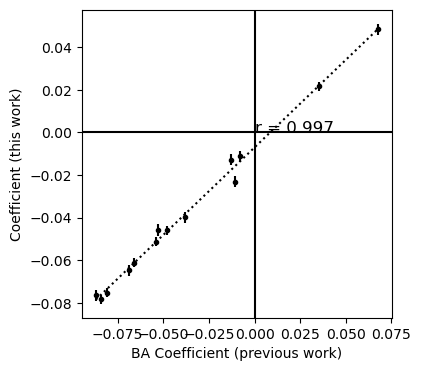

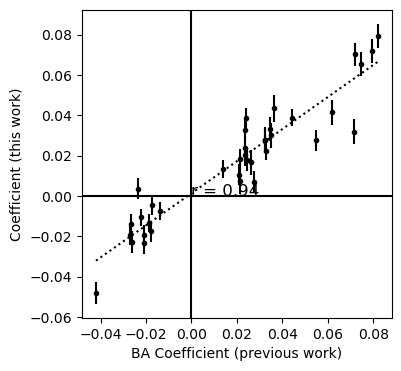

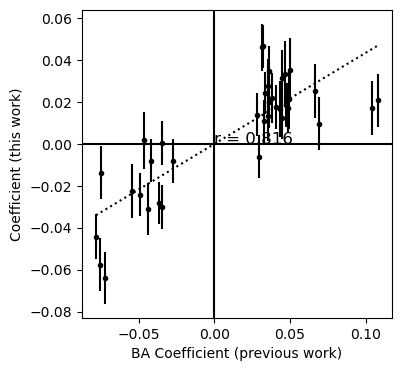

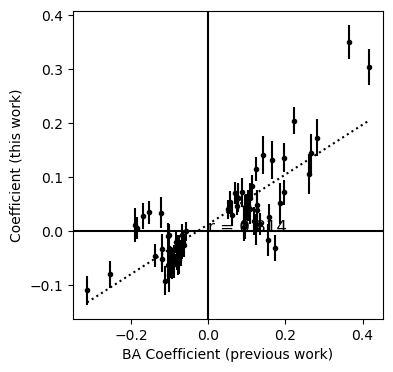

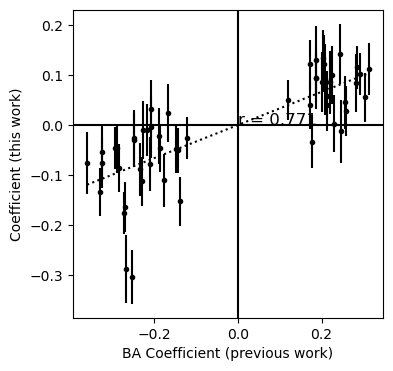

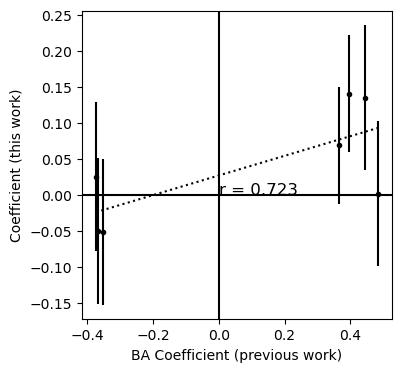

In [4]:
#######################################################################
## Calculate background-averaged epistatic coefficients for tRNA ##
#######################################################################

#Load data
input_file = os.path.join(data_dir, "tRNA/P.txt")
fitness_df = pd.read_csv(input_file, sep = "\t")
fitness_df['id_ref'] = fitness_df['id']

mut_dict = {
    'a': "g1a", 
    'b': "t2g", 
    'c': "t2c", 
    'd': "g3t", 
    'e': "g3a", 
    'f': "c4t", 
    'g': "a5c", 
    'h': "c6t", 
    'i': "c7t", 
    'j': "c7a", 
    'k': "a8g", 
    'l': "a9t", 
    'm': "a9g", 
    'n': "c10t"}
mut_dict_ref = {
    'a': "G1A", 
    'b': "U2G", 
    'c': "U2C", 
    'd': "G6U", 
    'e': "G6A", 
    'f': "C27U", 
    'g': "A43C", 
    'h': "C46U", 
    'i': "C66U", 
    'j': "C66A", 
    'k': "A69G", 
    'l': "A70U", 
    'm': "A70G", 
    'n': "C71U"}
avar_df = pd.DataFrame()
avar_df['nt_seq'] = [''.join(i) for i in list(itertools.product(
    ['0', 'a'], 
    ['0', 'b', 'c'], 
    ['0', 'd', 'e'],
    ['0', 'f'],
    ['0', 'g'],
    ['0', 'h'],
    ['0', 'i', 'j'],
    ['0', 'k'],
    ['0', 'l', 'm'],
    ['0', 'n']))]
avar_df = avar_df.sort_values('nt_seq')

#Recode
seq_mat = np.array([list(s) for s in avar_df['nt_seq']])
avar_df['id'] = ['_'.join([mut_dict[j] for j in i if j!='0']) for i in seq_mat]
avar_df['id_ref'] = [','.join([mut_dict_ref[j] for j in i if j!='0']) for i in seq_mat]
avar_df.loc[0,'id_ref'] = '-0-'

#Mutant order
avar_df['mut_order'] = [len(i.split('_')) for i in avar_df['id']]
avar_df.loc[avar_df['id_ref']=='-0-','mut_order'] = 0

#Add measured fitness
avar_df = avar_df.merge(fitness_df.loc[:,['fitness', 'SE', 'id_ref']], on = 'id_ref', how = 'outer')
#Fill missing fitness with mean fitness and errors at each order
mut_order_fitness_means = avar_df.groupby('mut_order')[['fitness']].mean()
mut_order_SE_means = avar_df.groupby('mut_order')[['SE']].mean()
for i in range(11):
    if i!=0:
        avar_df.loc[(avar_df['mut_order']==i) & (np.isnan(avar_df['fitness'])),'fitness'] = mut_order_fitness_means.iloc[i,:]['fitness']
        avar_df.loc[(avar_df['mut_order']==i) & (np.isnan(avar_df['SE'])),'SE'] = mut_order_SE_means.iloc[i,:]['SE']

#Background-averaged epistatic coefficients and errors
vhmat = np.matmul(
        V_matrix(
            str_coef = avar_df['nt_seq'],
            num_states = [2,3,3,2,2,2,3,2,3,2],
            invert = False), 
        H_matrix(
            str_geno = avar_df['nt_seq'],
            str_coef = avar_df['nt_seq'],
            num_states = [2,3,3,2,2,2,3,2,3,2],
            invert = False))
avar_df['coef_BA_est'] = np.matmul(
    vhmat, 
    avar_df['fitness'])
avar_df['coef_BA_est_sigma'] = np.power(np.matmul(
    vhmat*vhmat, 
    avar_df['SE']*avar_df['SE']), 0.5)

#Merge with published coefficients
var_df['id_ref'] = var_df['Mutant']
avar_df = avar_df.merge(var_df.loc[:,['id_ref', 'coef_BA', 'coef_order', 'n_bckg', 'global_qval_all']], on = 'id_ref', how = 'inner')

#Plot comparison with published coefficients up to 6th order
for i in [1,2,3,4,5,6]:
    plot_df = avar_df.loc[(avar_df['coef_order']==i) & (avar_df['global_qval_all']<0.05) & (avar_df['n_bckg']>10),:]
    corr_coef_BA = np.round(np.corrcoef(plot_df['coef_BA'], plot_df['coef_BA_est'])[0,1], 3)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot()
    plt.plot(plot_df['coef_BA'], plot_df['coef_BA_est'], '.', color = 'black', linewidth=0)
    plt.errorbar(plot_df['coef_BA'], plot_df['coef_BA_est'],
        color = 'black', yerr = [1.96*plot_df['coef_BA_est_sigma'], 1.96*plot_df['coef_BA_est_sigma']], fmt ='none')        
    x = plot_df['coef_BA']
    y = plot_df['coef_BA_est']
    coef = np.polyfit(x, y,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(np.asarray([min(x), max(x)]), poly1d_fn(np.asarray([min(x), max(x)])), ':', color = 'black')
    plt.xlabel("BA Coefficient (previous work)")
    plt.ylabel("Coefficient (this work)")
    plt.text(0, 0, 'r = '+str(corr_coef_BA), fontsize=12)
    plt.axhline(color = 'black')
    plt.axvline(color = 'black')
    plt.savefig('validation_scatter_BA_coeforder' + str(i) + '.pdf', format="pdf", bbox_inches="tight", transparent=True)
    plt.show()

In [5]:
#######################################################################
## Calculate background-averaged epistatic coefficients for eqFP611 ##
#######################################################################

#Load data
mut_list = ['D1N', 'V2A', 'L3M', 'T4P', 'F5S', 'N6A', 'S7G', 'A8C', 'A9L', 'Y10R', 'N11D', 'N12K', 'K13R']
input_file = os.path.join(data_dir, "eqFP611/41467_2019_12130_MOESM7_ESM_reformat.txt")
var_df = pd.read_csv(input_file, sep = "\t")
var_df['coef_order'] = var_df['Nham_aa']

#Recode WT
wt_seq = list(var_df.loc[var_df['WT']==True,'aa_seq'][0])
seq_mat = np.array([list(s) for s in var_df['aa_seq']])
seq_mat[seq_mat == wt_seq] = '0'
var_df['aa_seq'] = [''.join(s) for s in seq_mat]
var_df['id'] = ['_'.join(np.array(mut_list)[i]) for i in (seq_mat != '0')]

#Sort
var_df = var_df.sort_values('aa_seq')

#Background-averaged epistatic coefficients
var_df['coef_BA'] = np.matmul(
    np.matmul(
        V_matrix(
            str_coef = var_df['aa_seq'],
            num_states = 2,
            invert = False), 
        H_matrix(
            str_geno = var_df['aa_seq'],
            str_coef = var_df['aa_seq'],
            num_states = 2,
            invert = False)), 
    var_df['fitness'])

#Background-relative epistatic coefficients
var_df['coef_BR'] = np.matmul(
    G_matrix(
        sequence_length = 13,
        num_states = 2,
        invert = False), 
    var_df['fitness'])

#Save
var_df.to_csv("41467_2019_12130_MOESM7_ESM_reformat_coef.txt", index = False, sep = "\t")


In [6]:
#######################################################################
## Simulate combinatorial DMS dataset of DNA 6-mer ##
#######################################################################

#All genotypes
sequence_length = 6
num_states = 4
all_geno = genotypeLandscape(
    sequence_length = sequence_length,
    num_states = num_states)

#Interacting positions
int_pos = ["1_2", "3_5", "5_6"]

#Set random seed
np.random.seed(1)

#Data.Frame
var_df = pd.DataFrame({'nt_seq': all_geno})
var_df['Nham_nt'] = [len(i.replace("0", "")) for i in var_df['nt_seq']]
#Convert to ACGT
var_df['nt_seq'] = [i.replace("c", "t") for i in var_df['nt_seq']]
var_df['nt_seq'] = [i.replace("b", "g") for i in var_df['nt_seq']]
var_df['nt_seq'] = [i.replace("a", "c") for i in var_df['nt_seq']]
var_df['nt_seq'] = [i.replace("0", "a") for i in var_df['nt_seq']]
var_df['WT'] = np.nan
var_df.loc[var_df['Nham_nt']==0,'WT'] = True
var_df['Pos'] = ""
var_df.loc[var_df['Nham_nt']==2,'Pos'] = ['_'.join([str(j+1) for j in range(len(i)) if list(i)[j]!='a']) for i in var_df.loc[var_df['Nham_nt']==2,'nt_seq']]
var_df['coef'] = 0
var_df.loc[var_df['Nham_nt']==1,'coef'] = np.random.normal(-1, scale=2, size=sum(var_df['Nham_nt']==1))
var_df['int_pos'] = False
var_df.loc[(var_df['Nham_nt']==2) & [i in int_pos for i in var_df['Pos']],'int_pos'] = True
var_df.loc[var_df['int_pos']==True,'coef'] = np.random.normal(0, scale=1, size=sum(var_df['int_pos']==True))
var_df['coef_order'] = var_df['Nham_nt']
#Add id
wt_seq = list(var_df.loc[var_df['WT']==True,'nt_seq'][0])
seq_mat = np.array([list(s) for s in var_df['nt_seq']])
seq_mat[seq_mat == wt_seq] = '0'
seq_matid = []
for i in range(seq_mat.shape[1]):
    seq_matid += [np.array(['a'+str(i+1)+s for s in seq_mat[:,i]])]
seq_matid = np.transpose(np.array(seq_matid))
var_df['id'] = ['_'.join([j for j in i if j[-1]!='0']) for i in seq_matid]
    
#Background-averaged fitness
var_df['fitness_BA'] = np.matmul(
    np.matmul(
        H_matrix(
            str_geno = all_geno,
            str_coef = all_geno,
            num_states = num_states,
            invert = True), 
        V_matrix(
            str_coef = all_geno,
            num_states = num_states,
            invert = True)),
    var_df['coef'])

#Background-relative fitness
var_df['fitness_BR'] = np.matmul(
    G_matrix(
        sequence_length = sequence_length,
        num_states = num_states,
        invert = True), 
    var_df['coef'])

#Sigma
var_df['sigma'] = 0.1

#Set random seed
np.random.seed(1)

#Add noise
var_df['noise01'] = np.random.normal(0, scale=0.1, size=len(var_df))
var_df['noise05'] = np.random.normal(0, scale=0.5, size=len(var_df))
var_df['noise1'] = np.random.normal(0, scale=1, size=len(var_df))
var_df['noise2'] = np.random.normal(0, scale=2, size=len(var_df))
var_df['noise3'] = np.random.normal(0, scale=3, size=len(var_df))
var_df['fitness_BA_noise01'] = var_df['fitness_BA'] + var_df['noise01']
var_df['fitness_BA_noise05'] = var_df['fitness_BA'] + var_df['noise05']
var_df['fitness_BA_noise1'] = var_df['fitness_BA'] + var_df['noise1']
var_df['fitness_BA_noise2'] = var_df['fitness_BA'] + var_df['noise2']
var_df['fitness_BA_noise3'] = var_df['fitness_BA'] + var_df['noise3']
var_df['fitness_BR_noise01'] = var_df['fitness_BR'] + var_df['noise01']
var_df['fitness_BR_noise05'] = var_df['fitness_BR'] + var_df['noise05']
var_df['fitness_BR_noise1'] = var_df['fitness_BR'] + var_df['noise1']
var_df['fitness_BR_noise2'] = var_df['fitness_BR'] + var_df['noise2']
var_df['fitness_BR_noise3'] = var_df['fitness_BR'] + var_df['noise3']

#Save
var_df['coef_BA'] = var_df['coef']
var_df['coef_BR'] = var_df['coef']
var_df.to_csv("simulated_comb6mer.txt", index = False, sep = "\t")